In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d sumn2u/garbage-classification-v2


Dataset URL: https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2
License(s): MIT
 97% 725M/744M [00:03<00:00, 227MB/s]
100% 744M/744M [00:04<00:00, 194MB/s]


In [ ]:
!unzip garbage-classification-v2.zip


Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: garbage-dataset/paper/paper_847.jpg  
  inflating: garbage-dataset/paper/paper_848.jpg  
  inflating: garbage-dataset/paper/paper_849.jpg  
  inflating: garbage-dataset/paper/paper_851.jpg  
  inflating: garbage-dataset/paper/paper_852.jpg  
  inflating: garbage-dataset/paper/paper_853.jpg  
  inflating: garbage-dataset/paper/paper_855.jpg  
  inflating: garbage-dataset/paper/paper_856.jpg  
  inflating: garbage-dataset/paper/paper_857.jpg  
  inflating: garbage-dataset/paper/paper_859.jpg  
  inflating: garbage-dataset/paper/paper_861.jpg  
  inflating: garbage-dataset/paper/paper_863.jpg  
  inflating: garbage-dataset/paper/paper_865.jpg  
  inflating: garbage-dataset/paper/paper_868.jpg  
  inflating: garbage-dataset/paper/paper_870.jpg  
  inflating: garbage-dataset/paper/paper_871.jpg  
  inflating: garbage-dataset/paper/paper_873.jpg  
  inflating: garbage-dataset/paper/paper_874.jpg  
  inflating: garbage-dataset/paper/

In [1]:
import os
import shutil
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, models
from torchvision.transforms.functional import to_pil_image, pad
from PIL import Image
import matplotlib.pyplot as plt


In [ ]:

# Main directory path
dataset_dir = "garbage-dataset"

#  Output directories
output_dir = "split-dataset"
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "validation")
test_dir = os.path.join(output_dir, "test")

# Ratios for train, validation, and test splits
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Create directories
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

# Apply the process for each category
for category in os.listdir(dataset_dir):
    category_path = os.path.join(dataset_dir, category)
    if os.path.isdir(category_path):
        # Dosyaları topla
        files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]
        random.shuffle(files)  # Dosyaları karıştır

        # Calculate the split boundaries
        train_split = int(train_ratio * len(files))
        val_split = int((train_ratio + val_ratio) * len(files))

        # Split files into train, validation, and test sets
        train_files = files[:train_split]
        val_files = files[train_split:val_split]
        test_files = files[val_split:]

        # Move files to their respective directories
        for file_list, target_dir in zip([train_files, val_files, test_files], [train_dir, val_dir, test_dir]):
            category_target_dir = os.path.join(target_dir, category)
            os.makedirs(category_target_dir, exist_ok=True)
            for file in file_list:
                src = os.path.join(category_path, file)
                dst = os.path.join(category_target_dir, file)
                shutil.copy(src, dst)

print("Dataset successfully split!!")


Dataset successfully split!!


Loaded 13300 valid images.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


Epoch 1, Loss: 0.8749
Epoch 2, Loss: 0.5533
Epoch 3, Loss: 0.4781
Epoch 4, Loss: 0.3922
Epoch 5, Loss: 0.3617
Epoch 6, Loss: 0.2744
Epoch 7, Loss: 0.2404
Epoch 8, Loss: 0.2270
Epoch 9, Loss: 0.2158
Epoch 10, Loss: 0.2186
Pre-training tamamlandı!


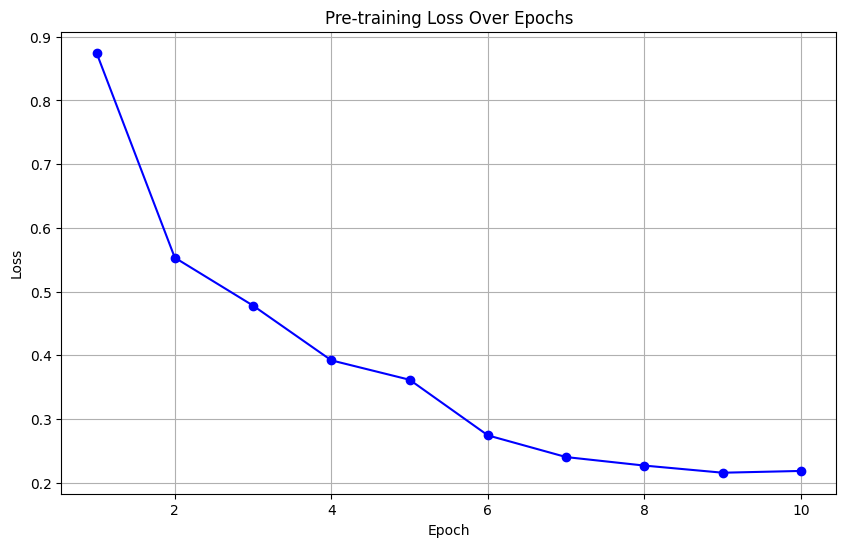

In [ ]:

# Dataset path
unlabeled_dataset_path = "/content/split-dataset/train"


def get_normalize_transform(num_channels):
    if num_channels == 3:  # RGB
        return transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    elif num_channels == 1:  # Grayscale
        return transforms.Normalize(mean=[0.5], std=[0.5])
    else:
        raise ValueError(f"Beklenmeyen kanal sayısı: {num_channels}")

# Data Augmentation - To create two different views of the same image
transform_augment = transforms.Compose([
    transforms.RandomResizedCrop(size=128, scale=(0.2, 1.0)),  # Wider cropping range
    transforms.RandomHorizontalFlip(),  # Horizontal flipping
    transforms.RandomRotation(degrees=15),   # Slight rotation
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.ToTensor(),
])

# Normalisation
transform_normalize = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Custom collate_fn function
def collate_fn(batch):
    max_height = max([img.shape[1] for img in batch])
    max_width = max([img.shape[2] for img in batch])

    padded_batch = []
    for idx, img in enumerate(batch):
        if img.shape[0] == 1:  # Grayscale images
            img = img.repeat(3, 1, 1)  # Convert to RGB
        elif img.shape[0] == 4:  # RGBA images
            img = img[:3, :, :]  # Remove the alpha channel

        padding = [0, 0, max_width - img.shape[2], max_height - img.shape[1]]
        padded_img = pad(img, padding, fill=0)
        padded_batch.append(padded_img)

    return torch.stack(padded_batch)

# Dataset definition
class UnlabeledDataset(Dataset):
    def __init__(self, root_dir, transform=None, augment=None):
        self.root_dir = root_dir
        self.transform = transform
        self.augment = augment
        self.image_paths = []
        for class_dir in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_dir)
            if os.path.isdir(class_path):
                for fname in os.listdir(class_path):
                    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                        image_path = os.path.join(class_path, fname)
                        try:
                            img = Image.open(image_path)
                            if img.mode in ['RGB', 'L']:  # Only accept RGB and Grayscale images
                                self.image_paths.append(image_path)
                        except Exception as e:
                            print(f"Error loading {image_path}: {e}")
        print(f"Loaded {len(self.image_paths)} valid images.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Convert all images to RGB
        if self.augment:
            # Create two different augmented versions of the image
            augmented_image1 = self.augment(image)
            augmented_image2 = self.augment(image)
            return augmented_image1, augmented_image2
        if self.transform:
            image = self.transform(image)
        return image

# Dataset and DataLoader
unlabeled_dataset = UnlabeledDataset(root_dir=unlabeled_dataset_path, augment=transform_augment)
unlabeled_loader = DataLoader(
    unlabeled_dataset,
    batch_size=64,  # Batch size is increased
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x))
)

# SimCLR model
class SimCLR(nn.Module):
    def __init__(self, base_model):
        super(SimCLR, self).__init__()
        self.base_model = base_model
        self.projection_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),  # Extra normalization layer
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128)  # Extra normalization
        )

    def forward(self, x):
        features = self.base_model(x)
        projections = self.projection_head(features)
        projections = nn.functional.normalize(projections, dim=1)
        return projections

# Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1):  # Smaller temperature parameter
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        if z_i.size(0) != z_j.size(0):
            raise ValueError(f"Batch size mismatch: z_i {z_i.size(0)}, z_j {z_j.size(0)}")

        batch_size = z_i.size(0)
        z = torch.cat((z_i, z_j), dim=0)
        sim_matrix = torch.matmul(z, z.T) / self.temperature
        sim_matrix_exp = torch.exp(sim_matrix)

        # Mask diagonal elements
        mask = torch.eye(batch_size * 2, device=z.device).bool()
        sim_matrix_exp = sim_matrix_exp.masked_fill(mask, 0)

        # Calculate positive similarities
        pos_sim = torch.exp(torch.sum(z_i * z_j, dim=-1) / self.temperature)
        pos_sim = torch.cat([pos_sim, pos_sim], dim=0)  # Repeat for both z_i and z_j

        # Clamp to prevent division by zero or log(0)
        denominator = sim_matrix_exp.sum(dim=-1).clamp(min=1e-8)
        loss = -torch.log(pos_sim / denominator)
        return loss.mean()

# Model and optimization
base_model = models.resnet18(pretrained=True)  # Pre-trained backbone
base_model.fc = nn.Identity()
simclr_model = SimCLR(base_model)

contrastive_loss = ContrastiveLoss()
optimizer = optim.Adam(simclr_model.parameters(), lr=1e-3)  # Optimized learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)   # Scheduler added to adjust learning rate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use GPU if available, otherwise CPU
simclr_model.to(device)

# Pre-training loop
loss_values = []

for epoch in range(10):
    simclr_model.train()
    epoch_loss = 0
    for batch in unlabeled_loader:
        images_aug1, images_aug2 = batch
        images_aug1 = torch.stack(images_aug1).to(device)
        images_aug2 = torch.stack(images_aug2).to(device)


        z_i = simclr_model(images_aug1)
        z_j = simclr_model(images_aug2)

        # Loss calculation
        loss = contrastive_loss(z_i, z_j)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    average_loss = epoch_loss / len(unlabeled_loader)
    loss_values.append(average_loss)
    print(f"Epoch {epoch+1}, Loss: {average_loss:.4f}")
    scheduler.step()

print("Pre-training tamamlandı!")

#Drawing Loss Values
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', linestyle='-', color='b')
plt.title('Pre-training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


Epoch 1, Train Loss: 1.6615, Validation Loss: 1.5984, Validation Accuracy: 81.36%
Epoch 2, Train Loss: 1.5835, Validation Loss: 1.6003, Validation Accuracy: 81.05%
Epoch 3, Train Loss: 1.5579, Validation Loss: 1.5660, Validation Accuracy: 84.52%
Epoch 4, Train Loss: 1.5410, Validation Loss: 1.5733, Validation Accuracy: 84.36%
Epoch 5, Train Loss: 1.5397, Validation Loss: 1.5462, Validation Accuracy: 86.85%
Epoch 6, Train Loss: 1.5209, Validation Loss: 1.5681, Validation Accuracy: 84.29%
Epoch 7, Train Loss: 1.5094, Validation Loss: 1.5793, Validation Accuracy: 83.61%
Epoch 8, Train Loss: 1.5067, Validation Loss: 1.5495, Validation Accuracy: 86.75%
Epoch 9, Train Loss: 1.4988, Validation Loss: 1.5555, Validation Accuracy: 85.91%
Epoch 10, Train Loss: 1.4958, Validation Loss: 1.5460, Validation Accuracy: 86.55%
Epoch 11, Train Loss: 1.5032, Validation Loss: 1.5411, Validation Accuracy: 86.88%
Epoch 12, Train Loss: 1.4889, Validation Loss: 1.5411, Validation Accuracy: 87.59%
Epoch 13, Tra

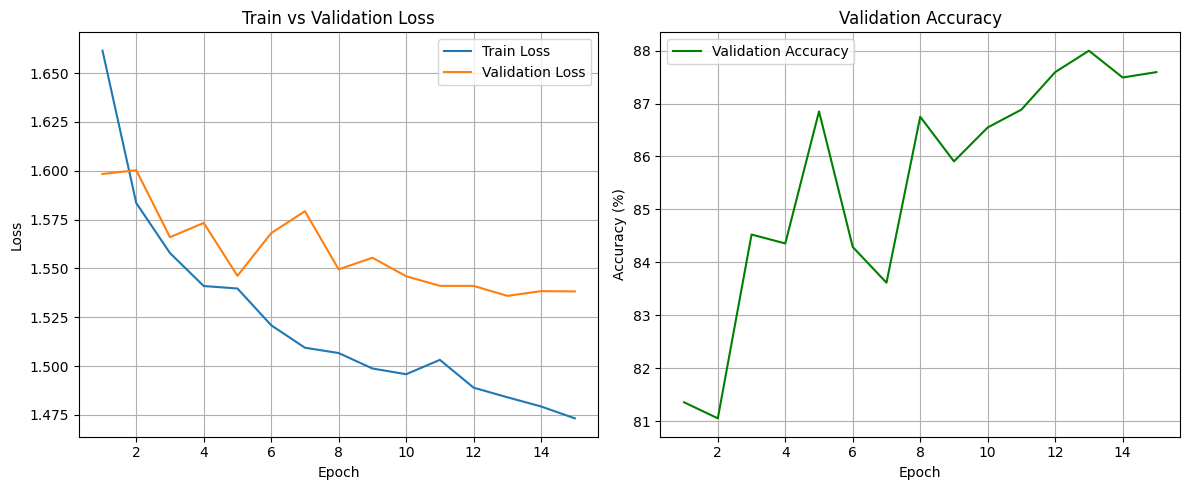

In [ ]:

# Dataset Paths
train_path = "/content/split-dataset/train"
val_path = "/content/split-dataset/validation"
test_path = "/content/split-dataset/test"  # Şu an kullanılmayacak

# Data Augmentation and Normalization
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)), # Resize the image
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Loading Datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=val_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Model Preparation
num_classes = len(train_dataset.classes)  # Determine the number of classes
simclr_model.projection_head = nn.Linear(512, num_classes)  # Add a new classification head
simclr_model.to(device)

# Optimizer and Loss
optimizer = optim.Adam(simclr_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Training and Validation
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(15):  # 15 epoch fine-tuning
    simclr_model.train()
    epoch_train_loss = 0

    # Training Loop
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = simclr_model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_loader))

    # Validation Loop
    simclr_model.eval()
    epoch_val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = simclr_model(images)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()

            # Accuracy Calculation
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(epoch_val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.2f}%")

# Plotting Loss and Accuracy after Training
plt.figure(figsize=(12, 5))

# Train and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid()

# Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:

#RANDOM SEARCH

# Dataset Paths
train_path = "/content/split-dataset/train"
val_path = "/content/split-dataset/validation"

# Data Augmentation and Normalization
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=128, scale=(0.7, 1.0)),  # Random cropping
    transforms.RandomHorizontalFlip(),  # Horizontal flip for augmentation
    transforms.RandomRotation(degrees=15),  # Small rotations for augmentation
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # Adjust brightness and contrast
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with standard mean and std
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Loading Datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=val_transform)

# Hyperparameter ranges for Random Search
param_space = {
    "learning_rate": [1e-3, 5e-4, 1e-4],  # Learning rate values to test
    "weight_decay": [1e-4, 1e-5, 1e-6],  # Weight decay values to test
    "dropout": [0.3, 0.5, 0.6],  # Dropout rates to test
    "batch_size": [16, 32, 64]  # Batch sizes to test
}

# Random selection of hyperparameter combinations
num_random_samples = 10  # Number of random hyperparameter combinations to test
random_combinations = [
    {
        "learning_rate": random.choice(param_space["learning_rate"]),
        "weight_decay": random.choice(param_space["weight_decay"]),
        "dropout": random.choice(param_space["dropout"]),
        "batch_size": random.choice(param_space["batch_size"])
    }
    for _ in range(num_random_samples)
]

# To store the results
results = []

# Random Search Loop
for params in random_combinations:
    lr = params["learning_rate"]
    weight_decay = params["weight_decay"]
    dropout = params["dropout"]
    batch_size = params["batch_size"]

    print(f"Testing combination: LR={lr}, WD={weight_decay}, Dropout={dropout}, Batch Size={batch_size}")

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Model Preparation
    num_classes = len(train_dataset.classes)
    simclr_model.projection_head = nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(256, num_classes)
    )
    simclr_model.to(device)

    # Optimizer and Loss
    optimizer = optim.AdamW(simclr_model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Training and Validation
    val_accuracies = []

    for epoch in range(5):  # Test each combination for 5 epochs
        simclr_model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = simclr_model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation Loop
        simclr_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = simclr_model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

    avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)
    results.append({"params": params, "accuracy": avg_val_accuracy})

    print(f"Combination: LR={lr}, WD={weight_decay}, Dropout={dropout}, Batch Size={batch_size}, "
          f"Val Accuracy: {avg_val_accuracy:.2f}%")

# Find the best result
best_result = max(results, key=lambda x: x["accuracy"])
best_params = best_result["params"]

print("\nBest Hyperparameter Combination:")
print(f"Learning Rate: {best_params['learning_rate']}, Weight Decay: {best_params['weight_decay']}, "
      f"Dropout: {best_params['dropout']}, Batch Size: {best_params['batch_size']}")
print(f"Validation Accuracy: {best_result['accuracy']:.2f}%")

# List all results
print("\nAll Results:")
for idx, result in enumerate(results):
    params = result["params"]
    accuracy = result["accuracy"]
    print(f"{idx + 1}. LR={params['learning_rate']}, WD={params['weight_decay']}, Dropout={params['dropout']}, "
          f"Batch Size={params['batch_size']}, Val Accuracy={accuracy:.2f}%")


Testing combination: LR=0.0005, WD=1e-06, Dropout=0.6, Batch Size=32
Combination: LR=0.0005, WD=1e-06, Dropout=0.6, Batch Size=32, Val Accuracy: 87.68%
Testing combination: LR=0.0001, WD=1e-06, Dropout=0.3, Batch Size=32
Combination: LR=0.0001, WD=1e-06, Dropout=0.3, Batch Size=32, Val Accuracy: 90.60%
Testing combination: LR=0.001, WD=1e-06, Dropout=0.6, Batch Size=16
Combination: LR=0.001, WD=1e-06, Dropout=0.6, Batch Size=16, Val Accuracy: 81.77%
Testing combination: LR=0.001, WD=1e-05, Dropout=0.3, Batch Size=64
Combination: LR=0.001, WD=1e-05, Dropout=0.3, Batch Size=64, Val Accuracy: 87.32%
Testing combination: LR=0.0005, WD=1e-06, Dropout=0.5, Batch Size=16
Combination: LR=0.0005, WD=1e-06, Dropout=0.5, Batch Size=16, Val Accuracy: 88.12%
Testing combination: LR=0.001, WD=1e-05, Dropout=0.5, Batch Size=32
Combination: LR=0.001, WD=1e-05, Dropout=0.5, Batch Size=32, Val Accuracy: 86.82%
Testing combination: LR=0.0001, WD=1e-05, Dropout=0.6, Batch Size=16
Combination: LR=0.0001, W

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

model_save_path = "/content/drive/MyDrive/best_simclr_model.pth"

if os.path.exists(model_save_path):
    print(f"Warning: {model_save_path} already exists and will be overwritten.")

torch.save(simclr_model.state_dict(), model_save_path)
print(f"Model saved successfully to {model_save_path}")


Mounted at /content/drive
Model saved successfully to /content/drive/MyDrive/best_simclr_model.pth


<ipython-input-9-6d68a5c9a05f>:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model.load_state_dict(torch.load(model_save_path))


Test Accuracy: 88.25%


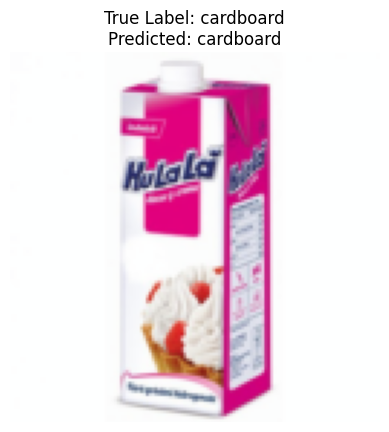

In [ ]:
# Test Set Path
test_path = "/content/split-dataset/test"

# Transform for the test set
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the test dataset and create a DataLoader
test_dataset = datasets.ImageFolder(root=test_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)  # Görselleştirme için batch size=1

# Retrieve the best hyperparameters from the random search results
best_lr = best_params['learning_rate']
best_weight_decay = best_params['weight_decay']
best_dropout = best_params['dropout']

#  Recreate the model with the best parameters
num_classes = len(test_dataset.classes)
simclr_model.projection_head = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(best_dropout),
    nn.Linear(256, num_classes)
)
simclr_model.to(device)

#  Load the saved model
model_save_path = "/content/drive/MyDrive/best_simclr_model.pth"
simclr_model.load_state_dict(torch.load(model_save_path))
simclr_model.eval()

# Evaluate the model on the test set
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = simclr_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Visualize a prediction from the test set
import matplotlib.pyplot as plt
import numpy as np

# Get a single test sample
data_iter = iter(test_loader)
image, label = next(data_iter)
image, label = image.to(device), label.to(device)

# Get the model's prediction
output = simclr_model(image)
_, predicted = torch.max(output, 1)

# Reverse normalization and prepare the image for visualization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_np = image.cpu().numpy().squeeze().transpose(1, 2, 0)
image_np = std * image_np + mean
image_np = np.clip(image_np, 0, 1)

# Display the image with the true and predicted labels
plt.imshow(image_np)
plt.title(f"True Label: {test_dataset.classes[label.item()]}\nPredicted: {test_dataset.classes[predicted.item()]}")
plt.axis('off')
plt.show()
